# Course 2 Project: ML Pipeline for Feature Engineering

## Instructions

In this project, you'll use data related to microeconomic indicators and historical stock prices to explore the data engineering pipline. You'll get to practice:

* Data ingestion 
* Data cleaning
* Data imputation
* Exploratory data analysis (EDA) through charts and graphs

## Packages

You'll use `pandas` and `matplotlib`, which were covered in the course material, to import, clean, and plot data. They have been installed in this workspace for you. If you're working locally and you installed Jupyter using Anaconda, these packages will already be installed. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime,timedelta,date

## Load data

The first step in a data engineering pipeline for machine learning is to ingest the data that will be used. For this project, data is hosted on a public GitHub repo. 

### Your tasks
* Import data from the provided [GitHub repo](https://github.com/udacity/CD13649-Project/tree/main/Project) using `pandas`. For your convenience, the data files (CSVs) are also present in the current workspace at the path **CD13649-Project/Project/**. Here are the data files to import: 
  1. GDP (**GDP.csv**)
  2. Inflation (**inflation_monthly.csv**)
  3. Apple stock prices (**apple_historical_data.csv**)
  4. Microsoft stock prices (**microsoft_historical_data.csv**)
  5. Consumer price index (**consumer_price_index.csv**)



* Verify that the data has been imported correctly into `pandas` dataframes. Use methods like `head()` and `info()`


* You may need to change column names to make them easier to work with


* You may need to cast datetime data to the `datetime` format using `pandas` `to_datetime()` method



In [2]:
# Load historical GDP data
gdp_df = pd.read_csv('GDP.csv')
gdp_df.head()


,DATE,GDP
0,1947-01-01,243.164
1,1947-04-01,245.968
2,1947-07-01,249.585
3,1947-10-01,259.745
4,1948-01-01,265.742


In [3]:
# Check the first few rows of data
cpi_df = pd.read_csv('consumer_price_index.csv')
cpi_df.head()

,DATE,CORESTICKM159SFRBATL
0,1968-01-01,3.651861
1,1968-02-01,3.673819
2,1968-03-01,4.142164
3,1968-04-01,4.155828
4,1968-05-01,4.088245


In [4]:
# Load the historical stock price data for Apple and Microsoft
apple_df = pd.read_csv('apple_historical_data.csv')
microsoft_df = pd.read_csv('microsoft_historical_data.csv')

In [5]:
microsoft_df['Date'] = pd.to_datetime(microsoft_df['Date'])
apple_df['Date']= pd.to_datetime(apple_df['Date'])
microsoft_df = microsoft_df.sort_values(by='Date', ascending=True)
apple_df = apple_df.sort_values(by='Date', ascending=True)
apple_df.set_index(apple_df['Date'],inplace =True)
microsoft_df.set_index(microsoft_df['Date'],inplace=True)

In [6]:
apple_df.head()

,Date,Close/Last,Volume,Open,High,Low
Date,,,,,,
2014-05-06,2014-05-06,$21.23,373872650,$21.49,$21.59,$21.23
2014-05-07,2014-05-07,$21.15,282128727,$21.26,$21.33,$20.99
2014-05-08,2014-05-08,$21.00,228973884,$21.01,$21.23,$20.94
2014-05-09,2014-05-09,$20.91,291068564,$20.88,$20.94,$20.73
2014-05-12,2014-05-12,$21.17,212736019,$20.98,$21.20,$20.98


In [7]:
# Check the first few rows of data
print(apple_df.head())
print(microsoft_df.head())

                 Date Close/Last     Volume     Open     High      Low
Date                                                                  
2014-05-06 2014-05-06    $21.23   373872650  $21.49   $21.59   $21.23 
2014-05-07 2014-05-07    $21.15   282128727  $21.26   $21.33   $20.99 
2014-05-08 2014-05-08    $21.00   228973884  $21.01   $21.23   $20.94 
2014-05-09 2014-05-09    $20.91   291068564  $20.88   $20.94   $20.73 
2014-05-12 2014-05-12    $21.17   212736019  $20.98   $21.20   $20.98 
                 Date Close/Last    Volume    Open    High     Low
Date                                                              
2014-05-06 2014-05-06     $39.06  27105700  $39.29  $39.35  $38.95
2014-05-07 2014-05-07    $39.425  41731030  $39.22  $39.51  $38.51
2014-05-08 2014-05-08     $39.64  32089010  $39.34  $39.90  $38.97
2014-05-09 2014-05-09     $39.54  29646100  $39.54  $39.85  $39.37
2014-05-12 2014-05-12     $39.97  22761620  $39.74  $40.02  $39.65


In [8]:
# Use methods like .info() and .describe() to explore the data

print(apple_df.describe(include='all'))
print(microsoft_df.describe(include='all'))
print(gdp_df.describe(include='all'))
print(cpi_df.describe(include='all'))


                                 Date Close/Last        Volume     Open  \
count                            2517       2514  2.517000e+03     2517   
unique                            NaN       2152           NaN     2143   
top                               NaN    $43.56            NaN  $29.20    
freq                              NaN          5           NaN        4   
mean    2019-05-04 02:21:18.665077248        NaN  1.277394e+08      NaN   
min               2014-05-06 00:00:00        NaN  2.404834e+07      NaN   
25%               2016-11-01 00:00:00        NaN  7.741776e+07      NaN   
50%               2019-05-06 00:00:00        NaN  1.077601e+08      NaN   
75%               2021-11-01 00:00:00        NaN  1.567789e+08      NaN   
max               2024-05-03 00:00:00        NaN  7.576780e+08      NaN   
std                               NaN        NaN  7.357405e+07      NaN   

           High      Low  
count      2517     2517  
unique     2155     2177  
top     $29.13   $

In [9]:
inflation_df = pd.read_csv('inflation_monthly.csv')
inflation_df.head(5)

,DATE,CORESTICKM159SFRBATL
0,1968-01-01,3.651861
1,1968-02-01,3.673819
2,1968-03-01,4.142164
3,1968-04-01,4.155828
4,1968-05-01,4.088245


## Data preprocessing: Check for missing data and forward fill

Check the Apple historical prices for missing data. Check for missing data in all columns. If there's data missing, use a forward fill to fill in those missing prices. 

In [10]:
# Check for nulls 

print(apple_df.isnull().sum(axis=0))

Date          0
Close/Last    3
Volume        0
Open          0
High          0
Low           0
dtype: int64


In [11]:
# Forward fill any missing data
apple_df['Close/Last'] = apple_df['Close/Last'].ffill()

In [12]:
# Check again for nulls after using forward fill
apple_df.isnull().sum(axis=0)

Date          0
Close/Last    0
Volume        0
Open          0
High          0
Low           0
dtype: int64

## Data preprocessing: Remove special characters and convert to numeric/datetime

The next step in the data engineering process is to standardize and clean up data. In this step, you'll check for odd formatting and special characters that will make it difficult to work with data as numeric or datetime. 

In this step:
* Create a function that takes in a dataframe and a list of columns and removes dollar signs ('$') from those columns
* Convert any columns with date/time data into a `pandas` `datetime` format

In [13]:
def convert_dollar_columns_to_numeric(df, numeric_columns):
    '''
        Removes dollar signs ('$') from a list of columns in a given dataframe AND casts the columns to a numeric datatype.
        Updates dataframe IN PLACE.
        
        Inputs:
            df: dataframe to be operated on
            numeric_columns: columns that should have numeric data but have dollar signs currently
            
        Returns:
            None - changes to the dataframe can be made in place
    '''
    numeric_columns = numeric_columns
    for col in numeric_columns:
        df[col] = df[col].str.replace('$','')
        df[col] = df[col].apply(pd.to_numeric)
        
    
    return df
    
    
 

In [14]:
# Use convert_dollar_columns_to_numeric() to remove the dollar sign from the Apple and Microsoft datasets
numeric_columns= [ 'Close/Last', 'Open', 'High', 'Low']
new_apple_df = convert_dollar_columns_to_numeric(apple_df, numeric_columns)
new_microsoft_df = convert_dollar_columns_to_numeric(microsoft_df, numeric_columns)


In [15]:
# Use pandas's to_datetime() to convert any columns that are in a datetime format

new_apple_df['Date'] = pd.to_datetime(new_apple_df['Date'])
new_microsoft_df['Date'] = pd.to_datetime(new_microsoft_df['Date'])

In [16]:
# Use .info() and check the type of each column to ensure that the above steps worked
print(new_apple_df.info())
new_microsoft_df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2014-05-06 to 2024-05-03
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        2517 non-null   datetime64[ns]
 1   Close/Last  2517 non-null   float64       
 2   Volume      2517 non-null   int64         
 3   Open        2517 non-null   float64       
 4   High        2517 non-null   float64       
 5   Low         2517 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 137.6 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2014-05-06 to 2024-05-03
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        2517 non-null   datetime64[ns]
 1   Close/Last  2517 non-null   float64       
 2   Volume      2517 non-null   int64         
 3   Open        2517 non-null   float64       
 4  

## Data preprocessing: Align datetime data

Data engineering includes changing data with a datetime component if needed so that different time series can be more easily compared or plotted against each other. 

In this step:

* Align the inflation date so that it falls on the last day of the month instead of the first

Helpful hints: 
* Use the `pandas` `offsets` method using `MonthEnd(0)` to set the 'Date' column to month-end

In [17]:
# Align inflation data so that the date is the month end (e.g. Jan 31, Feb 28/28)

from pandas.tseries.offsets import MonthEnd
inflation_df['DATE'] = pd.to_datetime(inflation_df['DATE'])

inflation_df_monthlyEnd = inflation_df['DATE'] + MonthEnd(0)
inflation_df_monthlyEnd .head()

0   1968-01-31
1   1968-02-29
2   1968-03-31
3   1968-04-30
4   1968-05-31
Name: DATE, dtype: datetime64[ns]

## Data preprocessing: Upsample, downsample and interpolate data

Inflation data is presented monthly in this dataset. However, for some models, you may need it at a quarterly frequency, and for some models you may need it at a quarterly frequency. 

In this step:
* Create a new quarterly inflation dataframe by downsampling the monthly inflation data to quarterly using the mean (e.g. for quarter 1 in a given year, use the average values from January, February, and March)
* Create a new weekly inflation dataframe by upsampling the monthly inflation data. For this, you'll need to use `resample` and then you'll need to `interpolate` to fill in the missing data at the weekly frequency

Note that you may need to change the index for some of these operations! 

In [18]:
# Upsample and interpolate from monthly to weekly 

inflation_df.set_index('DATE', inplace=True) 
inflation_df_weekly=inflation_df['CORESTICKM159SFRBATL'].resample('W').interpolate()
inflation_df_weekly

DATE
1968-01-07         NaN
1968-01-14         NaN
1968-01-21         NaN
1968-01-28         NaN
1968-02-04         NaN
                ...   
2024-02-04    4.882928
2024-02-11    4.882928
2024-02-18    4.882928
2024-02-25    4.882928
2024-03-03    4.882928
Freq: W-SUN, Name: CORESTICKM159SFRBATL, Length: 2931, dtype: float64

In [19]:
inflation_df_monthly=inflation_df['CORESTICKM159SFRBATL'].resample('QE').mean()

In [20]:
# Downsample from monthly to quarterly 

inflation_df_down_quartly = inflation_df['CORESTICKM159SFRBATL'].resample('QE').mean()
inflation_df_down_quartly.head()

DATE
1968-03-31    3.822615
1968-06-30    4.263214
1968-09-30    4.882643
1968-12-31    5.429443
1969-03-31    5.873770
Freq: QE-DEC, Name: CORESTICKM159SFRBATL, dtype: float64

## Data preprocessing: Normalize/standardize a feature

Economic time series data often involve variables measured on different scales (e.g., GDP in trillions of dollars, inflation in percentage points). Standardizing these variables (typically by subtracting the mean and dividing by the standard deviation) puts them on a common scale, allowing for meaningful comparisons and analyses.

Your task:
* Standardize the GDP data. You may do this manually by subtracting the mean and dividing by the standard deviation, or you may use a built-in method from a library like `sklearn`'s `StandardScaler`

In [21]:
# Standardize the GDP measure

gdp_df['Standardized']=(gdp_df.GDP - gdp_df.GDP.mean())/gdp_df.GDP.std()

In [22]:
# Check the dataframe to make sure the calculation worked as expected 

gdp_df.head()

,DATE,GDP,Standardized
0,1947-01-01,243.164,-0.933981
1,1947-04-01,245.968,-0.933606
2,1947-07-01,249.585,-0.933123
3,1947-10-01,259.745,-0.931764
4,1948-01-01,265.742,-0.930962


## EDA: Plotting a time series of adjusted open vs close price

As part of your EDA, you'll frequently want to plot two time series on the same graph and using the same axis to compare their movements. 

Your task:
* Plot the Apple open and close price time series on the same chart **for the last three months only**. Be sure to use a legend to label each line

**NOTE**: This is a large dataset. If you try to plot the entire series, your graph will be hard to interpret and may take a long time to plot. Be sure to use only the most recent three months of data. 

In [23]:
# Get max date in timeseries
end_date = apple_df.index.max()
start_date = end_date - pd.Timedelta(days=90)

In [24]:
# Use the max date calculated above to get the last three months of data in the dataset 

apple_df_90 = apple_df.loc[start_date:,]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


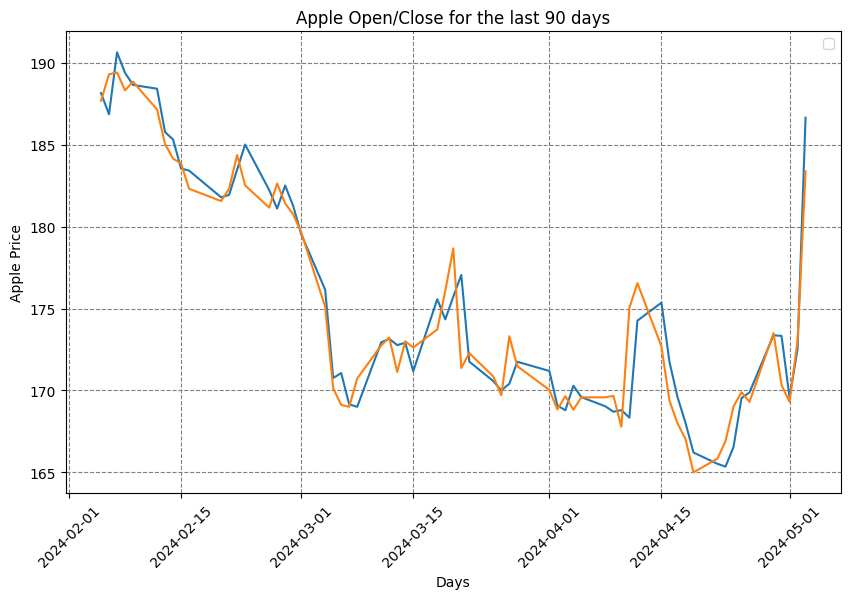

In [25]:
# Plot time series of open v. close stock price for Apple using the last 3 months of data

plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='Open', data=apple_df_90)
sns.lineplot(x='Date', y='Close/Last', data=apple_df_90)
plt.title('Apple Open/Close for the last 90 days')
plt.xlabel('Days')
plt.ylabel('Apple Price')
plt.grid(True, which='major', linestyle='--', color='grey')
plt.xticks(rotation=45)
plt.legend()
plt.show()


## EDA: Plotting a histogram of a stock's closing price in the last three months

One way to see how much a stock's price generally moves is to plot the frequency of closing prices over a set time period. 

Your task:
* Use the **last three months** of Apple stock data and plot a histogram of closing price

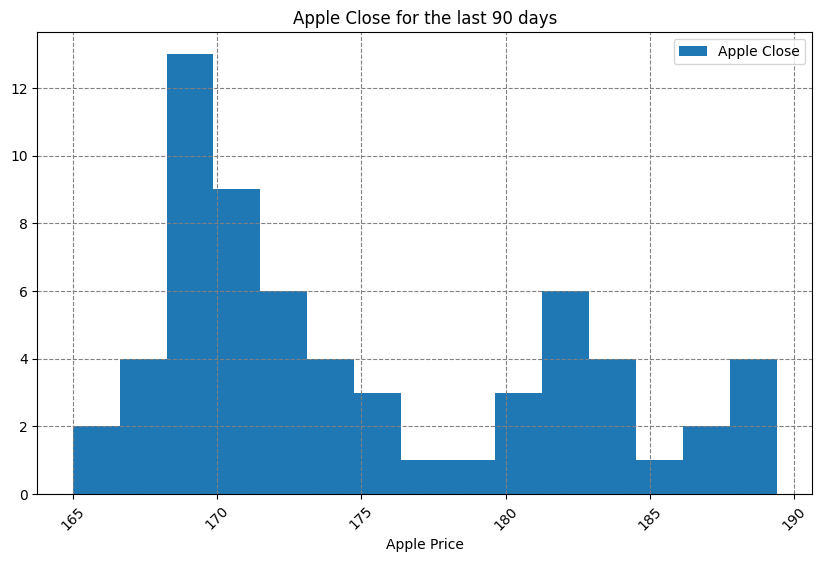

In [26]:
# Plot the histogram of Apple's closing price over the last 3 months 
plt.figure(figsize=(10, 6))
plt.hist(apple_df_90['Close/Last'], label='Apple Close',bins=15)
plt.title('Apple Close for the last 90 days')
plt.xlabel('Apple Price')
plt.grid(True, which='major', linestyle='--', color='grey')
plt.xticks(rotation=45)
plt.legend()
plt.show()


## Calculating correlation between a stock price and a macroeconomic variable 

Inflation affects the purchasing power of money and can influence corporate profits, interest rates, and consumer behavior. By analyzing the correlation between stock prices and inflation, one can gauge how inflationary trends impact stock market performance. For instance, high inflation might erode profit margins and reduce stock prices, while moderate inflation might indicate a growing economy, benefiting stocks.

Your task:
* Plot a heatmap that shows the correlation between Microsoft and Apple returns and inflation 

This will require several steps:
1. Calculate the returns for Apple and Microsoft and the change in monthly inflation (use the `pct_change` method for each)
2. Interpolate the daily stock returns data to monthly so it can be compared to the monthly inflation data
3. Merge the stock returns (Apple and Microsoft) and inflation data series into a single dataframe
4. Calculate the correlation matrix between the Apple returns, Microsoft returns, and inflation change
5. Plot the correlation matrix as a heatmap

### 1. Calculate returns for Microsoft / Apple and the monthly change in inflation

In [27]:
# Calculate daily returns for Apple and Microsoft and the percent change in inflation from month to month

apple_df['daily returns'] = apple_df['Close/Last'].pct_change()
microsoft_df['daily returns'] = microsoft_df['Close/Last'].pct_change()
inflation_df['change in monthly inflation'] = inflation_df['CORESTICKM159SFRBATL'].pct_change()

### 2. Interpolate stock returns from daily to monthly

In [28]:
apple_df_monthly_resample = (apple_df['daily returns']+1).resample('ME').prod() -1
microsoft_df_monthly_resample = (microsoft_df['daily returns'] +1).resample('ME').prod() - 1

In [29]:
'''apple_monthly_return = (apple_df_monthly_resample + 1).prod() - 1
microsoft_monthly_return = (microsoft_df_monthly_resample + 1).prod() - 1'''

'apple_monthly_return = (apple_df_monthly_resample + 1).prod() - 1\nmicrosoft_monthly_return = (microsoft_df_monthly_resample + 1).prod() - 1'

In [40]:
type(apple_df_monthly_resample)

pandas.core.series.Series

In [51]:
apple_microsoft_inflation_df = pd.concat([apple_df_monthly_resample,microsoft_df_monthly_resample,inflation_df_monthly],axis=1)

In [52]:
apple_microsoft_inflation_df = apple_microsoft_inflation_df.dropna()
apple_microsoft_inflation_df.shape

(40, 3)

### 4. Calculate the correlation matrix between the Apple returns, Microsoft returns, and inflation change

In [53]:
# Calculate correlation matrix
apple_microsoft_inflation_df.corr()

,daily returns,daily returns,CORESTICKM159SFRBATL
daily returns,1.000000,0.840484,-0.109500
daily returns,0.840484,1.000000,-0.046976
CORESTICKM159SFRBATL,-0.109500,-0.046976,1.000000


### 5. Plot the correlation matrix as a heatmap 

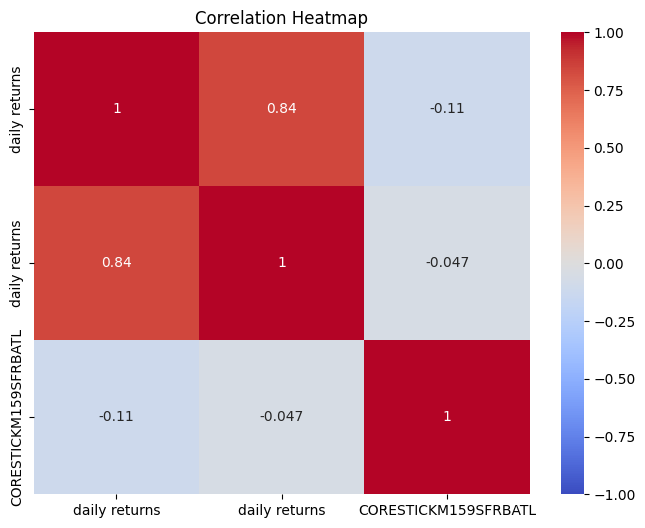

In [54]:
# Plot heatmap
df = apple_microsoft_inflation_df

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1) 
plt.title('Correlation Heatmap')
plt.show()


## Calculating rolling volatility (standard deviation) of a stock's price for last 3 months

Volatility is a measure of the dispersion of returns for a given security. By calculating rolling volatility, investors can assess the risk associated with a stock over time: Higher volatility indicates higher risk, as the stock's price is more likely to experience significant fluctuations. In portfolio optimization, understanding the volatility of individual stocks and how it changes over time is crucial for diversification and optimization. By analyzing rolling volatility, investors can adjust their portfolios to maintain a desired risk level, potentially improving the risk-return profile.

One possible way to calculate volatility is by using the standard deviation of returns for a stock over time.

Your task:
* Calculate the weekly rolling standard deviation for Apple's closing price
* Plot the calculated rolling weekly volatility of Apple's closing price against Apple's closing price. Plot these **on the same chart, but using different y-axes**

Helpful hints:
* You'll need to use the `pandas` `rolling()` method with a given `window_size` parameter to make it a _weekly_ rolling calculation
* Use **only the last three months of data**; data much older than this may not be as useful for portfolio optimization
* You'll need to create two axes on the matplotlib figure to be able to use two different y-axes (one for the closing price and one for the rolling volatility calculated here)

In [55]:
apple_df_90['returns'] = apple_df_90['Close/Last'].pct_change()

/tmp/ipykernel_31/3317652752.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_df_90['returns'] = apple_df_90['Close/Last'].pct_change()


In [56]:
# Define the window size for the rolling calculation (e.g., one week)
apple_df_rolling = apple_df_90['returns'].rolling(window=5)

In [57]:
# Calculate rolling one-week volatility
Apple_df_volatility= apple_df_rolling .std()

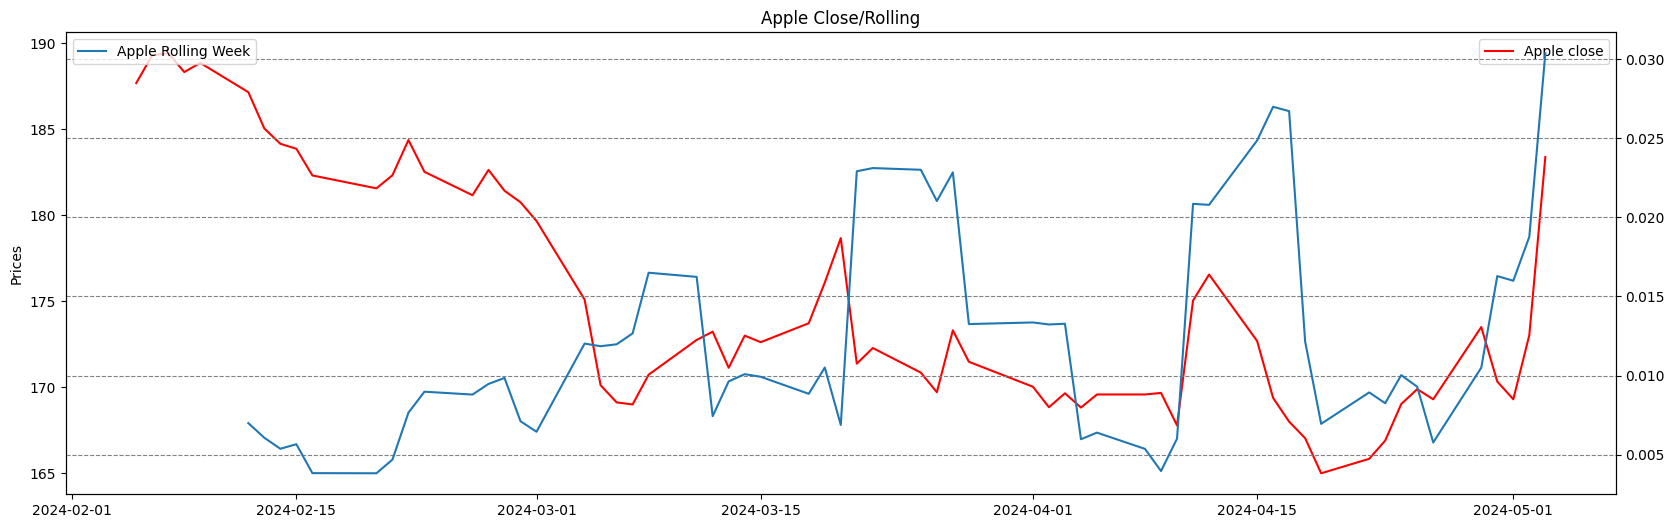

In [58]:
# Plot the calculated rolling weekly volatility of Apple's closing price against Apple's closing price
# Plot these on the same chart, but using different y-axes
fig, ax1 = plt.subplots(figsize=(20,6))
ax1.plot(apple_df_90['Close/Last'], label='Apple close',color='red')
ax1.set_title('Apple Close/Rolling')
ax1.set_ylabel('Prices')
ax2 = ax1.twinx()
ax2.plot(Apple_df_volatility, label='Apple Rolling Week')
plt.grid(True, which='major', linestyle='--', color='grey')
ax1.legend()
plt.legend()
plt.show();


## Export data

Now that you have preprocessed your data, you should save it in new csv files so that it can be used in downstream tasks without having to redo all the preprocessing steps. 

Your task:
* Use `pandas` to export all modified datasets back to new CSV files

In [59]:
apple_df.to_csv("apple_df.csv", index=False)
microsoft_df.to_csv("microsoft_df.csv", index=False)
gdp_df.to_csv("gdp_df.csv", index=False)
cpi_df.to_csv("cpi_df.csv", index=False)
apple_df_90.to_csv("apple_df_90", index=False)
new_apple_df.to_csv("new_apple_df", index=False)
new_microsoft_df.to_csv("new_microsoft_dfgdp_df.csv", index=False)
inflation_df_weekly.to_csv("inflation_df_weekly", index=False)
inflation_df_monthly.to_csv("inflation_df_monthly", index=False)
inflation_df_down_quartly.to_csv("inflation_df_down_quartly", index=False)
apple_microsoft_inflation_df.to_csv("apple_microsoft_inflation_df", index=False)